In [11]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils import shuffle 
import regex 
%pip install emoji
import emoji
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random 
import time 
import torch
import torch.nn.functional as F
%pip install transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from sentence_transformers import SentenceTransformer
from torch.utils.data import TensorDataset, random_split, DataLoader, SequentialSampler, RandomSampler
from transformers import get_linear_schedule_with_warmup
RANDOM_STATE = 256


torch.cuda.is_available()
cuda = torch.device('cuda')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def preprocess(path):
    
    """
    
    preprocess: takes path to single tweets.csv and cleans it
    
    params:
    
    - path: path to .csv file
    
    returns: 
    - x: cleaned data 
    - y: labels 
    
    use: only use on original train/val csv from kaggle 
    
    """ 

    dat = pd.read_csv(path)
    add_row = dat.columns.to_numpy()
    dat.loc[len(dat.index)] = add_row
    dat.columns = ["Index", "Source", "Sentiment", "Tweet"]

    x = pd.DataFrame(dat["Tweet"])
    y = pd.DataFrame(dat["Sentiment"])

    y.drop(dat[dat.isnull().any(axis=1)].index.to_numpy(), inplace=True)
    y.reset_index(inplace=True)
    y.drop("index", axis=1, inplace=True)
    x.drop(dat[dat.isnull().any(axis=1)].index.to_numpy(), inplace=True)
    x.reset_index(inplace=True)
    x.drop("index", axis=1, inplace=True)
    
    my_dict = {'positive':0, 'negative':1, 'neutral':2,'irrelevant':3}
    

    y = y.to_numpy()
    y[y == 'Positive'] = 0 
    y[y == 'Negative'] = 1
    y[y == 'Neutral'] = 2
    y[y == 'Irrelevant'] = 3
    x = x.to_numpy()



    x = x.flatten()
    y = y.astype(int).flatten()

    return (x, y)


def train_val_test(x, y, first_split=0.40, second_split=0.50, seed=256):
    
    """
    train_val_test: sped up function for train/test/splitting of cleaned .npy data 
    
    params: 
    - x: cleaned tweet.npy 
    - y: cleaned label.npy 
    - first_split: test split proportion for first split (train/unprocessed) 
    - second_split: test split proportion for second split of unprocessed (val/test)
    - seed: random seed for splitting 
    
    returns: 
    - dict of train/val/tst sets 
    
    """ 
    np.random.seed(seed)
    x_tr, x_mid, y_tr, y_mid = train_test_split(
        x, y, test_size=first_split, random_state=seed
    )
    x_val, x_tst, y_val, y_tst = train_test_split(
        x_mid, y_mid, test_size=second_split, random_state=seed
    )

    return {
        "x_tr": x_tr,
        "y_tr": y_tr,
        "x_val": x_val,
        "y_val": y_val,
        "x_tst": x_tst,
        "y_tst": y_tst,
    }


def to_loader(output, batch_size=32, type="tr"):
    
    """ 
    to_loader: 
    - compiles tokenized data into tensor datasets
    - turns tensor datasets into torch data loaders of specified batch_size
    
    params: 
    - output: len(3) tuple resulting from @tokenize function or regular (dat,lab) tuple  
    - batch_size: batch size for dataloaders 
    - type: must be in ['tr', 'val', 'tst'] 
        -- determines what type of random sampler to use 
        
    returns: 
    - dataloader: torch dataloader  
    
    """
    
    if len(output) == 3: 
    
        dat = TensorDataset(output[0], output[1], output[2])
        
        if type == "tr":
            dataloader = DataLoader(dat, sampler=RandomSampler(dat), batch_size=batch_size)
            return dataloader
        
        elif type in ["val", "tst"]:
            dataloader = DataLoader(
                dat, sampler=SequentialSampler(dat), batch_size=batch_size
            )
            
            return dataloader
        
    elif len(output) == 2: 
        
        dat = TensorDataset(output[0], output[1])
        
        if type == "tr":
            dataloader = DataLoader(dat, sampler=RandomSampler(dat), batch_size=batch_size)
            return dataloader
        
        elif type in ["val", "tst"]:
            dataloader = DataLoader(
                dat, sampler=SequentialSampler(dat), batch_size=batch_size
            )
            return dataloader
    

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text)

    return emoji_list + flags


def get_emoji(x): 
    emoji_list = [] 
    for i in range(0, len(x)): 
        text = x[i]
        emojis = split_count(text) 
        if len(emojis) > 0: 
            emoj_list.append(list(set(emojis)))
    emoj_flat = [item for sublist in emoj_list for item in sublist]

    return emoj_flat


def tokenize(x, y, tokenizer, emoji = False):

        """ 
        tokenize: takes in .numpy data and tokenizes using BertTokenizer 

        params: 
        - x: ,npy tweets
        - y: .npy labels 

        returns: 
        - input_ids: id tokens 
        - attention_masks: masks 
        - labels: labels 

        """

        if emoji is False: 

            input_ids = []
            attention_masks = []
            for sentence in x:
                encoded_dict = tokenizer.encode_plus(
                    sentence,
                    add_special_tokens=True,
                    max_length=64,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors="pt",
                    truncation=True,
                )
                input_ids.append(encoded_dict["input_ids"])
                attention_masks.append(encoded_dict["attention_mask"])
            input_ids = torch.cat(input_ids, dim=0).cuda()
            attention_masks = torch.cat(attention_masks, dim=0).cuda()
            labels = torch.tensor(y).type(torch.LongTensor).cuda()

            return (input_ids, attention_masks, labels)

        else: 

            emojis = get_emoji(x) 
            tokenizer.add_tokens(emojis)

            input_ids = []
            attention_masks = []
            for sentence in x:
                encoded_dict = tokenizer.encode_plus(
                    sentence,
                    add_special_tokens=True,
                    max_length=64,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors="pt",
                    truncation=True,
                )
                input_ids.append(encoded_dict["input_ids"])
                attention_masks.append(encoded_dict["attention_mask"])
            input_ids = torch.cat(input_ids, dim=0).cuda()
            attention_masks = torch.cat(attention_masks, dim=0).cuda()
            labels = torch.tensor(y).type(torch.LongTensor).cuda()

            return (input_ids, attention_masks, labels)


def data_pipe(X, Y, tokenizer, first_split=0.40, second_split=0.50, seed=256, batch_size=32, emoji = False):
    
    """ 
    data_pipe: splits, tokenizes, and returns data in dataloaders 
    
    params: 
    - X: tweet.npy 
    - Y: label.npy 
    - first_split: see @train_val_test 
    - second_split: see @train_val_test 
    - seed: see @train_val_test 
    - batch_size: see @to_loader
    
    returns: 
    - train_loader: loader for train dat 
    - val_loader: loader for val dat 
    - tst_loader: loader for tst dat
    
    """
    
    splits = train_val_test(X, Y, first_split, second_split, seed)
    tokenizer = tokenizer 
    train_token = tokenize(splits["x_tr"], splits["y_tr"], tokenizer, emoji)
    val_token = tokenize(splits["x_val"], splits["y_val"], tokenizer, emoji)
    tst_token = tokenize(splits["x_tst"], splits["y_tst"], tokenizer, emoji)

    train_loader = to_loader(train_token, batch_size, type = "tr")
    val_loader = to_loader(val_token, batch_size, type = "val")
    tst_loader = to_loader(tst_token, batch_size, type = "tst")

    return (train_loader, val_loader, tst_loader)



def flat_accuracy(preds, labels):
    
    """ 
    
    flat_accuracy: computes accuracy between preds and labels 
    
    params: 
    - preds: predictions
    - labels: labels 
    
    returns: 
    - accuracy
    
    """
    
    pred_flat = np.argmax(preds.numpy(), axis=1).flatten()
    labels_flat = labels.numpy().flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def f1_score_func(preds, labels):
    
    """ 
    f1_score_func: computes weighted f1 between preds and labels 
    
    params: 
    - preds: predictions
    - labels: labels 
    
    returns: 
    - weighted f1
    
    """
    
    preds_flat = np.argmax(preds.numpy(), axis=1).flatten()
    labels_flat = labels.numpy().flatten()
    return f1_score(labels_flat, preds_flat, average="weighted")

def finetune(path, model, train_loader, val_loader, tokenizer_length = None,  epochs=5, tolerance=0.01, patience = 2, emoji = False):
    
    """ 
    
    finetune: finetunes pretrained BertForSequenceClassification model on tweet data 
    
    params: 
    - path: path to store best model 
    - model: BertForSequenceClassificationModel 
    - train_loader: torch loader for train dat 
    - val_loader: torch loader for val dat 
    - epochs: number of times to iterate through data 
    - tolerance: decides how close a lower validation loss can be to a previous best 
    - patience: decides how long loss can be lower than previous best before function exits 
    
    returns: 
    - training_stats: dictionary of accuracy, f1, val loss, and training loss over epochs 
    
    """
    
    model = model
    
    if emoji: 
        
        model.resize_token_embeddings(tokenizer_length)
        

    train_loader = train_loader
    val_loader = val_loader

    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    seed_val = 256
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

    training_stats = {"acc": [], "f1": [], "val_loss": [], 'training_loss': []}
    val_loss_tracker = 2e5
    tolerance = tolerance

    for epoch_i in range(0, epochs):
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_loader):
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            model.zero_grad()
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = outputs.loss.cuda()
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        training_stats['training_loss'].append(avg_train_loss)
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        # evaluation
        model.eval()
        total_eval_accuracy = 0
        total_eval_f1 = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        for batch in val_loader:
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )
                loss = outputs.loss.cuda()
                logits = outputs.logits.cuda()

            total_eval_loss += loss.item()
            total_eval_f1 += f1_score_func(logits.cpu(), b_labels.cpu())
            total_eval_accuracy += flat_accuracy(logits.cpu(), b_labels.cpu())

        avg_val_accuracy = total_eval_accuracy / len(val_loader)
        avg_val_f1 = total_eval_f1 / len(val_loader)
        avg_val_loss = total_eval_loss / len(val_loader)
        training_stats["acc"].append(avg_val_accuracy)
        training_stats["f1"].append(avg_val_f1)
        training_stats["val_loss"].append(avg_val_loss)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        print("  F1: {0:.2f}".format(avg_val_f1))
        print("  Loss: {0:.2f}".format(avg_val_loss))
        if avg_val_loss < val_loss_tracker - tolerance:
            val_loss_tracker = avg_val_loss
            torch.save(model.state_dict(), path + "best_model.pth")
        elif avg_val_loss > val_loss_tracker + tolerance:
            print("Exiting. Current loss is worst that previous.")
            break
            
    return training_stats


def get_embeddings(model, loader): 

    """ 
    
    get_embeddings: 
    
    - (1) Uses BertModelForSequenceClassification with finetuned state_dict loaded 
                    to generate hidden state embeddings for sentences
    - (2) Uses BertModel with Finetuned state_dict loaded to generate pooled cls token embedding for sentences
    
    params: 
    - model: BertModel with Finetuned state_dict loaded or BertModelForSequenceClassification with finetuned state_dict
    - loader: desired data to generate embeddings for 
    
    returns: 
    - embeddings: pooled cls token sentence embeddings or hidden state sentence embeddings
    - labels: labels 
    
    see @BertModel https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert#transformers.BertModel
    
    
    """
    
    embedding_list = []
    label_list = []
    model.eval()
    
    if isinstance(model, BertForSequenceClassification): 


        for step, batch in enumerate(loader):
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    output_hidden_states=True,
                )
                hidden = outputs.hidden_states
                embedding = hidden[-1][:, 0, :]
                embedding_list.append(embedding.cpu())
                label_list.append(b_labels.cpu())

        embeddings = torch.cat(embedding_list, dim=0)
        labels = torch.cat(label_list, dim=0)
        
        return (embeddings, labels)

    
    else:  

        for step, batch in enumerate(loader):
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            with torch.no_grad():
                outputs = new_mod(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                )
                embedding_list.append(outputs.pooler_output.cpu())
                label_list.append(b_labels.cpu())

        embeddings = torch.cat(embedding_list, dim=0)
        labels = torch.cat(label_list, dim=0)

        return (embeddings, labels)
    
def test_on_batch(model, loader): 
    
    total_eval_f1 = 0
    total_eval_acc = 0
    
    for batch in loader:
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            logits = outputs.logits.cuda()

        total_eval_f1 += f1_score_func(logits.cpu(), b_labels.cpu())
        total_eval_acc += flat_accuracy(logits.cpu(), b_labels.cpu())
        
    avg_f1 = total_eval_f1/len(loader)
    avg_acc = total_eval_acc/len(loader)
    
    
    return (avg_f1, avg_acc)


def plot_tune_loss(stats_dict, title, y_lim = [0.1,1]): 
    
    """
    
    plot_tune_loss: plots the stats_dict returned from @finetune 
    
    params: 
    - stats_dict: return from @finetune 
    - y_lim: y_limits on graph 
    
    returns: 
    - fig: the plot 
    
    """
    avg_val_loss = stats_dict['val_loss']
    avg_acc = stats_dict['acc']
    avg_f1 = stats_dict['f1']
    avg_train_loss = stats_dict['training_loss']
    epoch_list = range(1, len(avg_val_loss)+1)
    
    %matplotlib inline
    fig = figure(figsize=(15, 15), dpi=800)

    plt.rcParams.update({"font.size": 22})
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("%")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5
    
    plt.plot(
    list(epoch_list),
    list(avg_f1),
    linewidth=lw,
    alpha=0.2,
    color= 'darkgreen',
    label= "F1 Score",
    marker="o",
    )

    plt.plot(
        list(epoch_list),
        list(avg_acc),
        linewidth=lw,
        alpha=0.2,
        color= 'darkblue',
        label= "Accuracy",
        marker="o",
        )

    plt.plot(
        list(epoch_list),
        list(avg_val_loss),
        linewidth=lw,
        alpha=0.2,
        color= 'darkred',
        label= "Validation Loss",
        marker="o",
        )
    
    plt.plot(
        list(epoch_list),
        list(avg_train_loss),
        linewidth=lw,
        alpha=0.2,
        color= 'purple',
        label= "Training Loss",
        marker="o",
        )
    
    plt.legend()
    plt.grid()
    
    return fig

def plot_knn(metric_distances, y_lim = [0.1, 1]):
    
    """
    
    plot_knn: plots the metric dictionary returned from @finetune 
    
    params: 
    - metric_distances: metric dictionary generated by knn gridsearch
    - y_lim: y_limits on graph 
    
    returns: 
    - fig: the plot 
    
    """
    
    %matplotlib inline

    fig = figure(figsize=(15, 15), dpi=800)
    plt.rcParams.update({"font.size": 22})
    
    if isinstance(metric_distances, dict): 
    
        plt.title("Hidden State Features. Across KNN Distance Metrics and NNeighbors")
        plt.xlabel("Neighbors")
        plt.ylabel("F1")
        plt.ylim(y_lim[0], y_lim[1])
        lw = 5

        colors = {'euclidean': 'darkred', 'cityblock': 'darkblue', 'cosine':'darkgreen', 'correlation':'purple'}
        for j in ["euclidean", "cityblock", "cosine", "correlation"]:
            plt.plot(
            list(range(1,len(metric_distances[j])+1)),
            list(metric_distances[j]),
            linewidth=lw,
            alpha=0.2,
            color= colors[j],
            label= j,
            marker="o",
            )


        plt.legend()
        plt.grid()

        return fig 
    
    if isinstance(metric_distances, list): 
        
        plt.title("Sentence Transformer Features Across KNN NNeighbors")
        plt.xlabel("Neighbors")
        plt.ylabel("F1")
        plt.ylim(y_lim[0], y_lim[1])
        lw = 5
        plt.plot(
            list(range(1,len(metric_distances)+1)),
            metric_distances, 
            linewidth = lw, 
            alpha = 0.2,
            color = "darkgreen",
            label = "F1",
            marker = "o"
        )
        plt.legend()
        plt.grid()
        
        return fig 
        

def plot_svc(score_dict, y_lim = [0.1, 0.9], c = 2, c_range = range(-5,5)): 
    %matplotlib inline

    fig = figure(figsize=(15, 15), dpi=800)

    plt.rcParams.update({"font.size": 22})
    plt.title("Hidden State Features. Across SVM Kernel and Regularization")
    plt.xlabel("C (Base " + str(c) + ")")
    plt.ylabel("F1")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5

    colors = {'poly': 'darkred', 'rbf': 'darkblue', 'sigmoid':'darkgreen', 'linear':'purple'}
    for j in ["poly", "rbf", "sigmoid", "linear"]:
        plt.plot(
        list(c_range),
        list(score_dict[j]),
        linewidth=lw,
        alpha=0.2,
        color= colors[j],
        label= j,
        marker="o",
        )


    plt.legend()
    plt.grid()
            
    return fig 

def plot_adaboost(scores, y_lim = [0.1, 0.9], depth = range(10,15)): 
    %matplotlib inline
    
    fig = figure(figsize = (15,15), dpi = 800) 
    
    plt.rcParams.update({"font.size": 22})
    plt.title("ADA-BOOST F1 by Depth")
    plt.xlabel("Depth")
    plt.ylabel("%")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5
    plt.plot(
        list(depth),
        list(scores),
        linewidth=lw,
        alpha=0.2,
        color="darkred",
        label="ADA F1",
        marker="o",
    )


    plt.legend()
    plt.grid()
    
    return fig 

def plot_rf(scores, y_lim = [0.1, 0.9], num_trees = range(100,1000,100)):
    
    %matplotlib inline 
    
    fig = figure(figsize = (15,15), dpi = 800) 
    
    plt.rcParams.update({"font.size": 22})
    plt.title("Random Forest F1 by Number of Trees")
    plt.xlabel("Trees")
    plt.ylabel("%")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5
    plt.plot(
        list(num_trees),
        list(scores),
        linewidth=lw,
        alpha=0.2,
        color="darkred",
        label="RF F1",
        marker="o",
    )
    
    plt.legend()
    plt.grid()
    
    return fig

In [3]:
from pywsd.utils import lemmatize_sentence
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import string
from nltk.corpus import stopwords
import nltk

(X, y) = preprocess('./data/twitter_training.csv')

# sentiment = SentimentIntensityAnalyzer()
# tokenizer = nltk.tokenize.TweetTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()
# # translator = str.maketrans('', '', string.punctuation)
# additional_stopwords = ['’', '–', '‘', '“', '”',
# 'u', 'v', 'f', '—', '…', 'w', 'x', 'c', 'g', 'q', '•', '»', 'b', 'n']

# transformed = []
# for i in range(0,len(X)): 
#     tweet = X[i]
#     sent = sentiment.polarity_scores(tweet)
#     # neg[i] = sent['neg']
#     # neu[i] = sent['neu']
#     # pos[i] = sent['pos']
#     # compound[i] = sent['compound']
#     # no_punc = tweet.translate(translator)
#     tweet = tweet.replace("’", '\'')
#     words = tokenizer.tokenize(tweet)
#     tweet = ' '.join([lemmatizer.lemmatize(w) for w in words])
#     # words = [word for word in words if word not in stopwords.words('english') and word not in additional_stopwords] # remove stopwords
#     transformed.append(tweet)
# print('done with lemmatization')

splits = train_val_test(X, y)

# vectorizer = TfidfVectorizer(stop_words='english')
# svd_model = TruncatedSVD(n_components=2000, n_iter=10, random_state=42)
# svd_transformer = Pipeline([('tfidf', vectorizer),
#                             ('svd', svd_model)])

# X_tr = svd_transformer.fit_transform(splits["x_tr"])
# X_val = svd_transformer.transform(splits["x_val"])
# X_tst = svd_transformer.transform(splits["x_tst"])


Warming up PyWSD (takes ~10 secs)... took 2.5239107608795166 secs.


In [37]:
(X, y) = preprocess('./data/twitter_training.csv')
splits = train_val_test(X, y)

n_components = [100, 500, 1000, 2000, 5000]
var_preserved = np.zeros(len(n_components))

for (i, n) in enumerate(n_components):
    vectorizer = TfidfVectorizer(stop_words='english')
    svd_model = TruncatedSVD(n_components=n, n_iter=5, random_state=42)
    svd_transformer = Pipeline([('tfidf', vectorizer), 
                                ('svd', svd_model)])
    x_tr = svd_transformer.fit_transform(splits["x_tr"])
    x_val = svd_transformer.transform(splits["x_val"])
    x_tst = svd_transformer.transform(splits["x_tst"])
    var_preserved[i] = sum(svd_model.explained_variance_ratio_)
    np.save(f'./tfidf_results/x_tr_{n}', x_tr)
    np.save(f'./tfidf_results/x_val_{n}', x_val)
    np.save(f'./tfidf_results/x_tst_{n}', x_tst)

np.save('./tfidf_results/lsi_var_preserved.npy', [0.1802642, 0.38882954, 0.50905166, 0.64670595, 0.83498066])
np.save('./tfidf_results/lsi_time.npy', [3.8, 15.4, 31.6, 119.4, 366.3])

In [6]:
# decide which to load
def load_data(n_comp = 500):
    X_tr = np.load(f'./tfidf_results/x_tr_{n_comp}.npy', allow_pickle=True)
    X_val = np.load(f'./tfidf_results/x_val_{n_comp}.npy', allow_pickle=True)
    X_tst = np.load(f'./tfidf_results/x_tst_{n_comp}.npy', allow_pickle=True)
    return (X_tr, X_val, X_tst)

In [5]:
from sklearn.neighbors import NearestNeighbors
from statistics import mode

def do_knn(X_tr, y_tr, X_te, y_te, k, metric):
    # regular knn for comparison
    y_pred = np.zeros((k, len(y_te)))
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=-1).fit(X_tr)
    distances, neighbors_list = nbrs.kneighbors(X_te)
    for (index, neighbors) in enumerate(neighbors_list):
        for j in range(k):
            predicted = mode(y_tr[neighbors[0:j+1]])
            y_pred[j, index] = predicted
                
    return y_pred

(X_tr, X_val, X_tst) = load_data(500)
# KNN grid search
metrics = ["euclidean", "cityblock", "cosine", "correlation"]
f1_scores = np.zeros((4, 9))
for (metric_idx, j) in enumerate(metrics):
    print(f'knn for dist metric: {j}')
    y_pred = do_knn(X_tr, splits['y_tr'], X_val, splits['y_val'], 9, metric=j)
    for (k_idx, pred) in enumerate(y_pred):
        f1_scores[metric_idx, k_idx] = f1_score(splits["y_val"], pred, average = 'weighted')

np.save('./tfidf_results/knn_grid.npy', f1_scores)

knn for dist metric: euclidean


KeyboardInterrupt: 

In [28]:
metrics = ["euclidean", "cityblock", "cosine", "correlation"]
(X_tr, X_val, X_tst) = load_data(5000)
knn_results = np.load('./tfidf_results/knn_grid.npy')
row = knn_results.argmax(axis=0)[0]
col = knn_results.argmax(axis=1)[0]
metric = metrics[row]
k = col+1
# 5000 components
best_knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1).fit(X_tr, splits["y_tr"])
best_preds = best_knn.predict(X_tst)
best_score = f1_score(splits["y_tst"], best_preds, average = 'weighted')
best_score # 0.9278295653097224

# Full dataset
vectorizer = TfidfVectorizer(stop_words='english')
full_X_tr = vectorizer.fit_transform(splits["x_tr"]).toarray()
full_X_val = vectorizer.transform(splits["x_val"])
full_X_tst = vectorizer.transform(splits["x_tst"]).toarray()
best_knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1).fit(full_X_tr, splits["y_tr"])
best_preds = best_knn.predict(full_X_tst)
best_score = f1_score(splits["y_tst"], best_preds, average = 'weighted')
best_score # 0.931​

(44397, 27668)


In [5]:
# SVM
(X_tr, X_val, X_tst) = load_data(500)

C = [np.float_power(2,i) for i in range(-5,5)]
kernels = ['poly', 'rbf', 'sigmoid'] 
kernel_score_dict = {"poly": [], "rbf": [], "sigmoid": []}

for kern in kernels:
    print(f'validation for kernel {kern}')
    for reg in C: 
        print(f'C={reg}')
        clf = SVC(C = reg, kernel = kern, max_iter = 100).fit(X_tr, splits['y_tr'])
        preds = clf.predict(X_val)
        score = f1_score(splits['y_val'], preds, average = 'weighted') 
        kernel_score_dict[kern].append(score)
        
np.save('./tfidf_results/svm_kernel_grid.npy', kernel_score_dict)

## SVM LINEAR

svc_scores = []
print(f'validation for linear')
for rg in C: 
    print(f'C={rg}')
    clf = LinearSVC(C = rg).fit(X_tr, splits['y_tr'])
    preds = clf.predict(X_val)
    score = f1_score(splits['y_val'], preds, average = "weighted")
    svc_scores.append(score)
np.save('./tfidf_results/linear_svm_grid.npy', svc_scores)

validation for kernel poly
C=0.03125


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.0625


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.125


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.25


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.5


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=1.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=2.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=4.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=8.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=16.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


validation for kernel rbf
C=0.03125


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.0625


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.125


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.25


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.5


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=1.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=2.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=4.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=8.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=16.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


validation for kernel sigmoid
C=0.03125


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.0625


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.125


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.25


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=0.5


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=1.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=2.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=4.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=8.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C=16.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


validation for linear
C=0.03125
C=0.0625
C=0.125
C=0.25
C=0.5
C=1.0
C=2.0
C=4.0
C=8.0
C=16.0


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
(X_tr, X_val, X_tst) = load_data(5000)
kernel_results = np.load('./tfidf_results/svm_kernel_grid.npy', allow_pickle=True)
linear_results = np.load('./tfidf_results/linear_svm_grid.npy', allow_pickle=True)

vectorizer = TfidfVectorizer(stop_words='english')
full_X_tr = vectorizer.fit_transform(splits["x_tr"])
full_X_val = vectorizer.transform(splits["x_val"])
full_X_tst = vectorizer.transform(splits["x_tst"])

best_svm = LinearSVC(C = 2**5).fit(X_tr, splits["y_tr"])
best_preds = best_svm.predict(X_tst)
best_score = f1_score(splits["y_tst"], best_preds, average = 'weighted')
print(best_score) # 0.7560338589516166

best_svm = LinearSVC(C = 2**5).fit(full_X_tr, splits["y_tr"])
best_preds = best_svm.predict(full_X_tst)
best_score = f1_score(splits["y_tst"], best_preds, average = 'weighted')
print(best_score) # 0.8511747696631603

/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7560338589516166


In [22]:
# NB test
from sklearn.naive_bayes import MultinomialNB
vectorizer = TfidfVectorizer(stop_words='english')
full_X_tr = vectorizer.fit_transform(splits["x_tr"])
full_X_val = vectorizer.transform(splits["x_val"])
full_X_tst = vectorizer.transform(splits["x_tst"])

print('mnb')
mnb = MultinomialNB().fit(full_X_tr, splits['y_tr'])
mnb_pred = mnb.predict(full_X_tst)
best_score = f1_score(splits["y_tst"], mnb_pred, average = 'weighted')
best_score # 0.712097


print('gnb')
gnb = GaussianNB()
gnb.fit(full_X_tr.toarray(), splits['y_tr'])
gnb_pred = gnb.predict(full_X_tst.toarray()) 
gnb_score = f1_score(splits['y_tst'], gnb_pred, average = "weighted")
gnb_score # 0.7039817832584795

(X_tr, X_val, X_tst) = load_data(5000)
print('lda')
lda = LinearDiscriminantAnalysis()
lda.fit(X_tr, splits['y_tr'])
lda_pred = lda.predict(X_tst)
lda_score = f1_score(splits['y_tst'], lda_pred, average = "weighted")
print(lda_score) # 0.7219379450647937

print('qda')
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_tr, splits['y_tr'])
qda_pred = qda.predict(X_tst)
qda_score = f1_score(splits['y_tst'], qda_pred, average = "weighted")
print(qda_score) # 0.7911087064411573

mnb
gnb
lda
0.7219379450647937
qda


/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.7911087064411573


In [68]:
# RF tuning
(X_tr, X_val, X_tst) = load_data(500)
n_estimators = [10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900]
rf_scores = []
for i in n_estimators: 
    print(f'T={i}')
    rf = RandomForestClassifier(n_estimators = i, n_jobs = -1).fit(X_tr, splits["y_tr"])
    preds = rf.predict(X_val) 
    score = f1_score(splits["y_val"], preds, average = 'weighted')
    rf_scores.append(score)

np.save('./tfidf_results/rf_grid.npy', rf_scores)

T=10
T=20
T=30
T=40
T=50
T=100
T=150
[0.7021353473132477, 0.7466095247647889, 0.7647447765286073, 0.7742565311854523, 0.7800641144318896, 0.798330764989609, 0.8016315652762528]


In [24]:
# RF test
rf_list = np.load('./tfidf_results/rf_grid.npy', allow_pickle = True) 
# print(rf_list)
# T = n_estimators[np.argmax(rf_list)] # 900 estimators, but levels off around 200
T = 200

(X_tr, X_val, X_tst) = load_data(5000)
print("best RF")
best_rf = RandomForestClassifier(n_estimators = T, n_jobs = -1).fit(X_tr, splits["y_tr"]) 
best_rf_preds = best_rf.predict(X_tst)
rf_score = f1_score(splits["y_tst"], best_rf_preds, average = 'weighted')
print(rf_score) # 0.8113104333042949

(X_tr, X_val, X_tst) = load_data(500)
print("best bagging")
rfbag = BaggingClassifier(n_estimators = T, n_jobs = -1).fit(X_tr, splits["y_tr"]) 
rfbag_preds = rfbag.predict(X_tst)
rfbag_score = f1_score(splits["y_tst"], rfbag_preds, average = 'weighted')
print(rfbag_score) # 0.78514

best RF
0.8113104333042949


In [24]:
T = 200
(X_tr, X_val, X_tst) = load_data(100)
adaboost_stats = []
for i in list(range(10,15)):
    print(f'max_depth={i}')
    tree = DecisionTreeClassifier(max_depth=i)
    a_clf = AdaBoostClassifier(
        tree, n_estimators=T, learning_rate=1, random_state=RANDOM_STATE
    )
    a_clf.fit(X_tr, splits['y_tr'])
    preds = a_clf.predict(X_val)
    score = f1_score(splits['y_val'], preds, average = 'weighted')
    adaboost_stats.append(score)
    
np.save('./tfidf_results/adaboost_grid.npy', adaboost_stats)

max_depth=10
max_depth=11
max_depth=12
max_depth=13
max_depth=14


In [79]:
## TEST Adaboost
(X_tr, X_val, X_tst) = load_data(500)
adaboost_results = np.load('./tfidf_results/adaboost_grid.npy', allow_pickle = True)
T = 200
depth = 10 + np.argmax(adaboost_results) # max at 12
tree = DecisionTreeClassifier(max_depth = depth)
a_clf = AdaBoostClassifier(tree, n_estimators = T, learning_rate = 1, random_state= RANDOM_STATE)
a_clf.fit(X_tr, splits['y_tr'])
preds = a_clf.predict(X_tst)
best = f1_score(splits['y_tst'], preds, average = 'weighted')
best # 0.6402874670577938


0.6346965434590888

In [81]:
T=200
vectorizer = TfidfVectorizer()
full_X_tr = vectorizer.fit_transform(splits["x_tr"]).toarray()
full_X_tst = vectorizer.transform(splits["x_tst"]).toarray()
gb_clf = HistGradientBoostingClassifier(learning_rate=1, random_state=RANDOM_STATE)
ovo_clf = OneVsOneClassifier(gb_clf, n_jobs=-1)
ovo_clf.fit(full_X_tr, splits['y_tr'])
logit_preds = ovo_clf.predict(full_X_tst) 
logit_score = f1_score(splits['y_tst'], logit_preds, average = "weighted")
logit_score # 0.7175586365101817

# gradient boosting on 500: 0.5990435675151752

KeyboardInterrupt: 

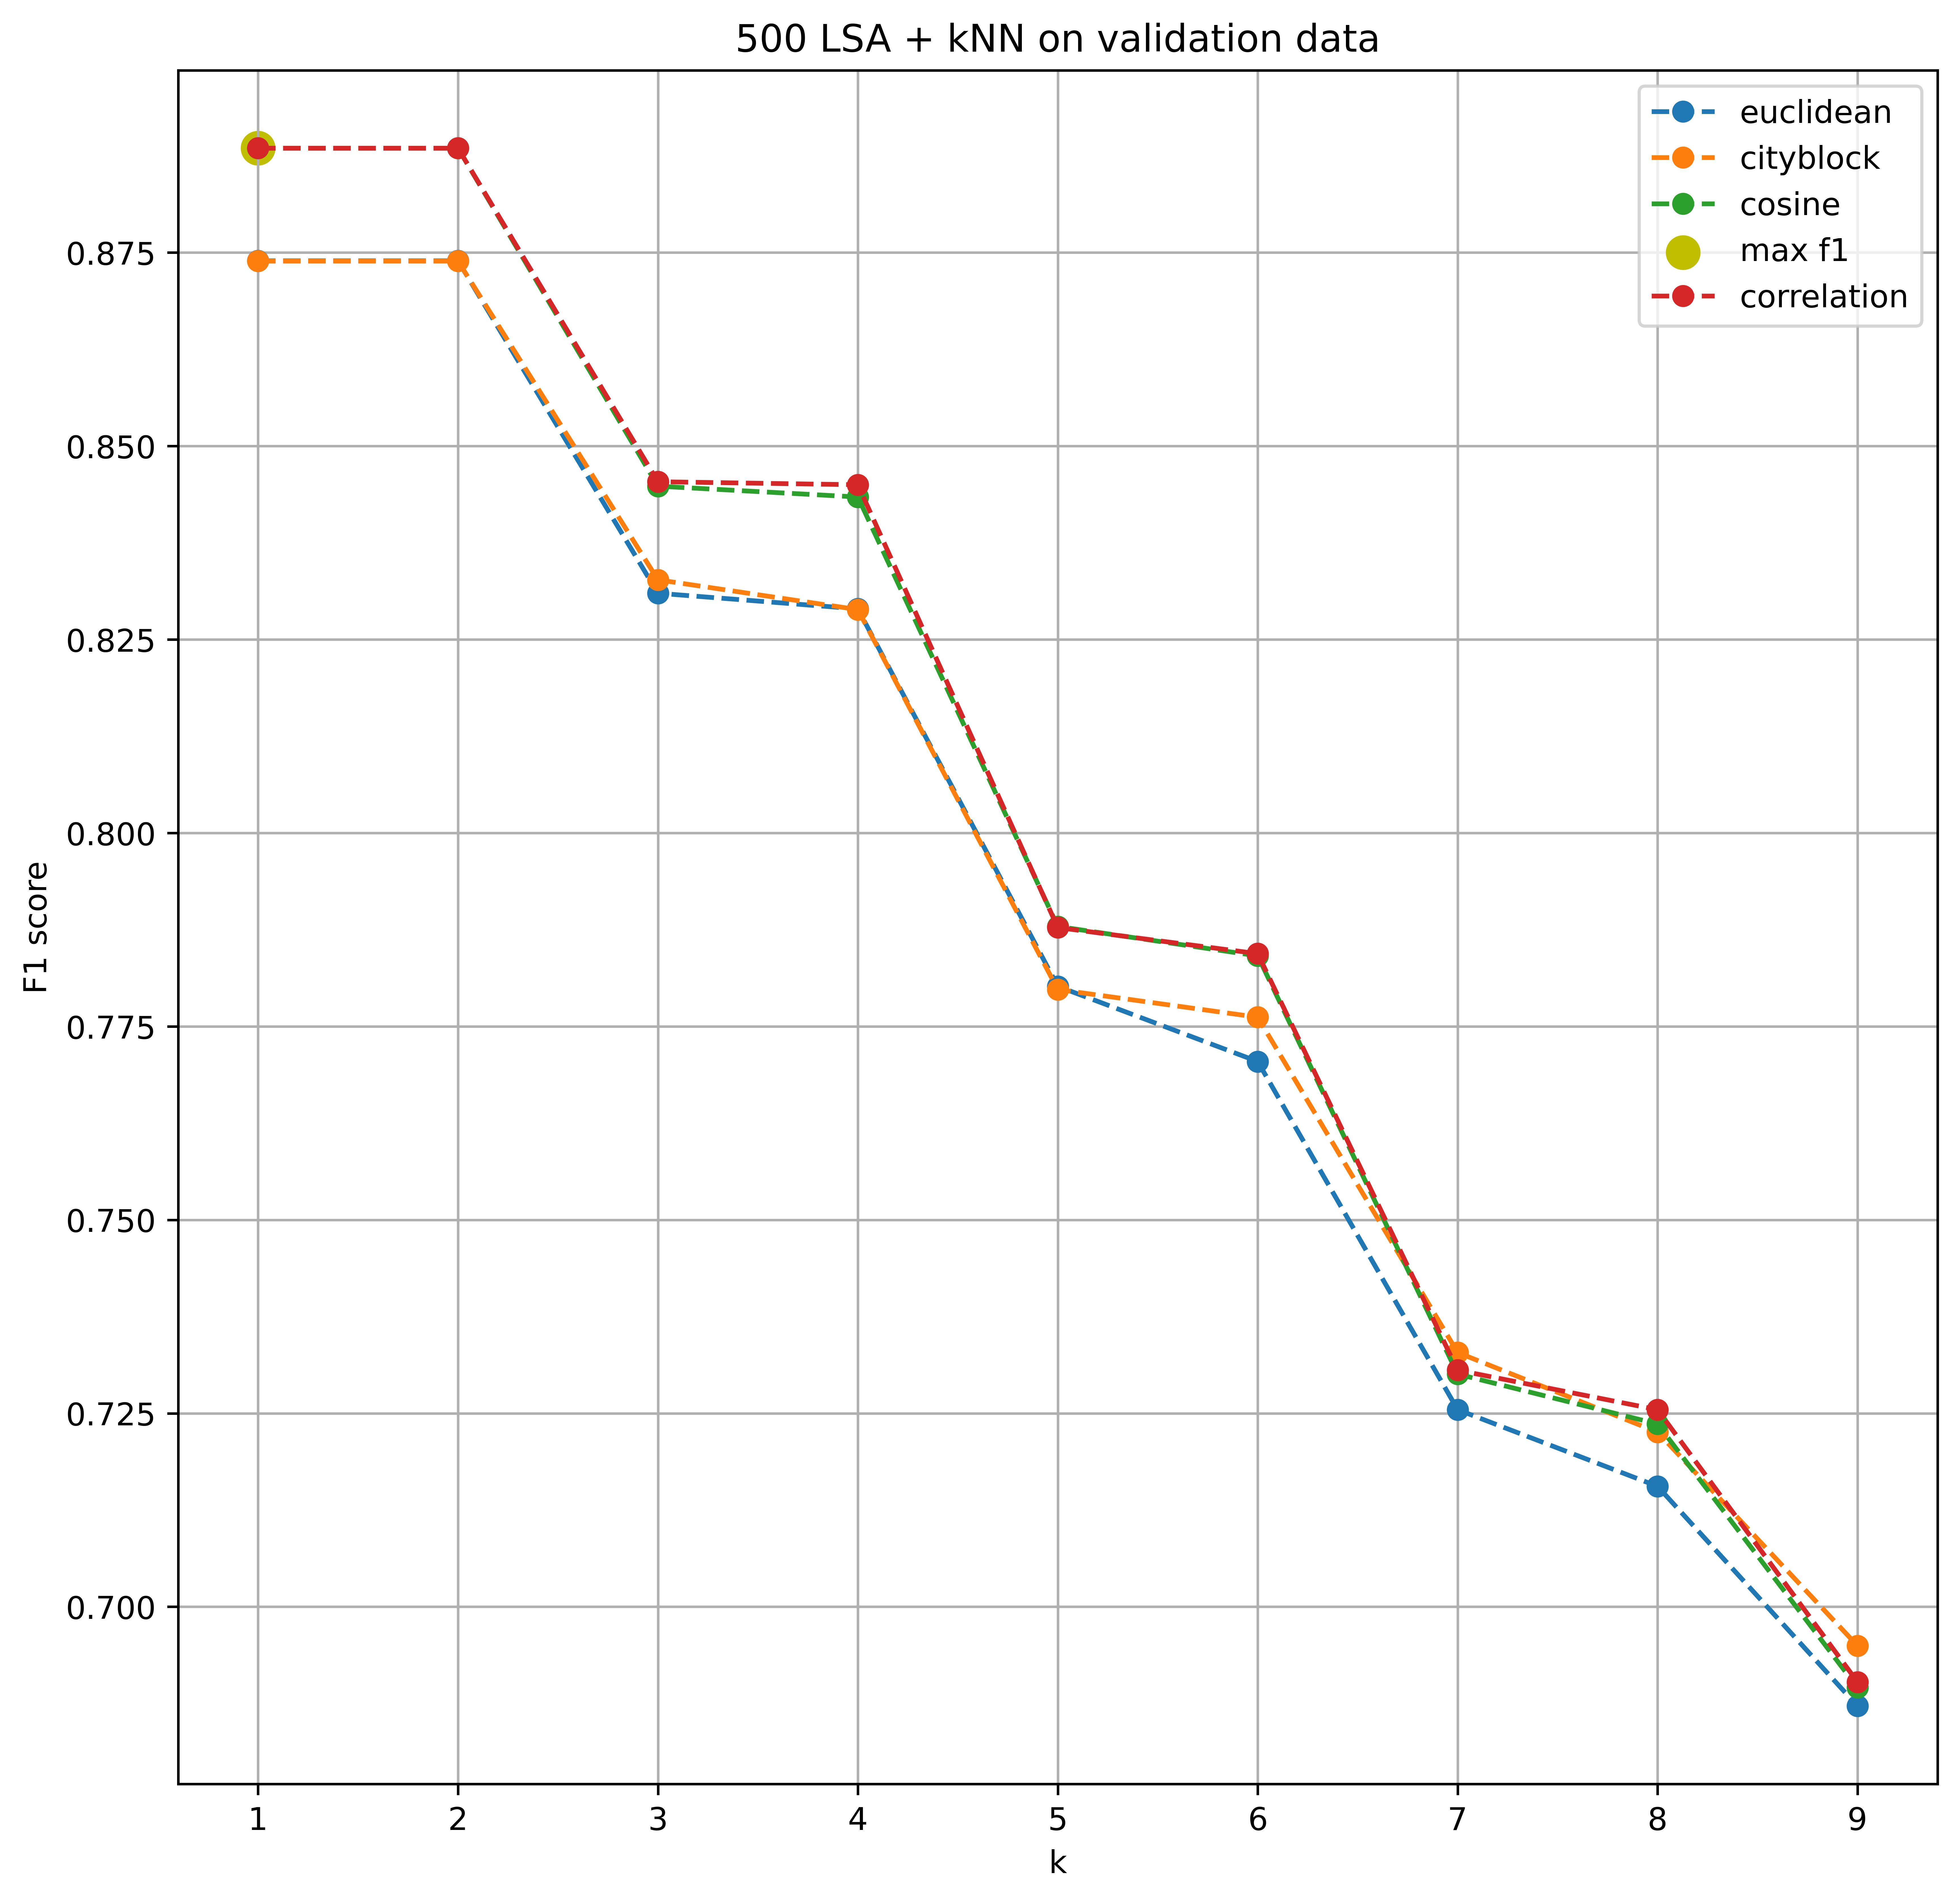

In [54]:
metrics = ["euclidean", "cityblock", "cosine", "correlation"]
knn_results = np.load('./tfidf_results/knn_grid.npy')
row = knn_results.argmax(axis=0)[0]
col = knn_results.argmax(axis=1)[0]
max = knn_results.max()

fig = figure(figsize=(10, 10), dpi=800)
for (i, metric) in enumerate(metrics):
    plt.plot(np.arange(1,len(knn_results[i])+1),knn_results[i],linestyle='--', marker='o', label=metric)
    if(i == row):
        plt.scatter(col+1, max,c='y', label='max f1', s=100)
plt.legend()
plt.grid()
plt.xlabel('k')
plt.ylabel('F1 score')
plt.title('500 LSA + kNN on validation data')
fig.savefig('tfidf_results/figures/knn_plot.jpg', bbox_inches='tight')

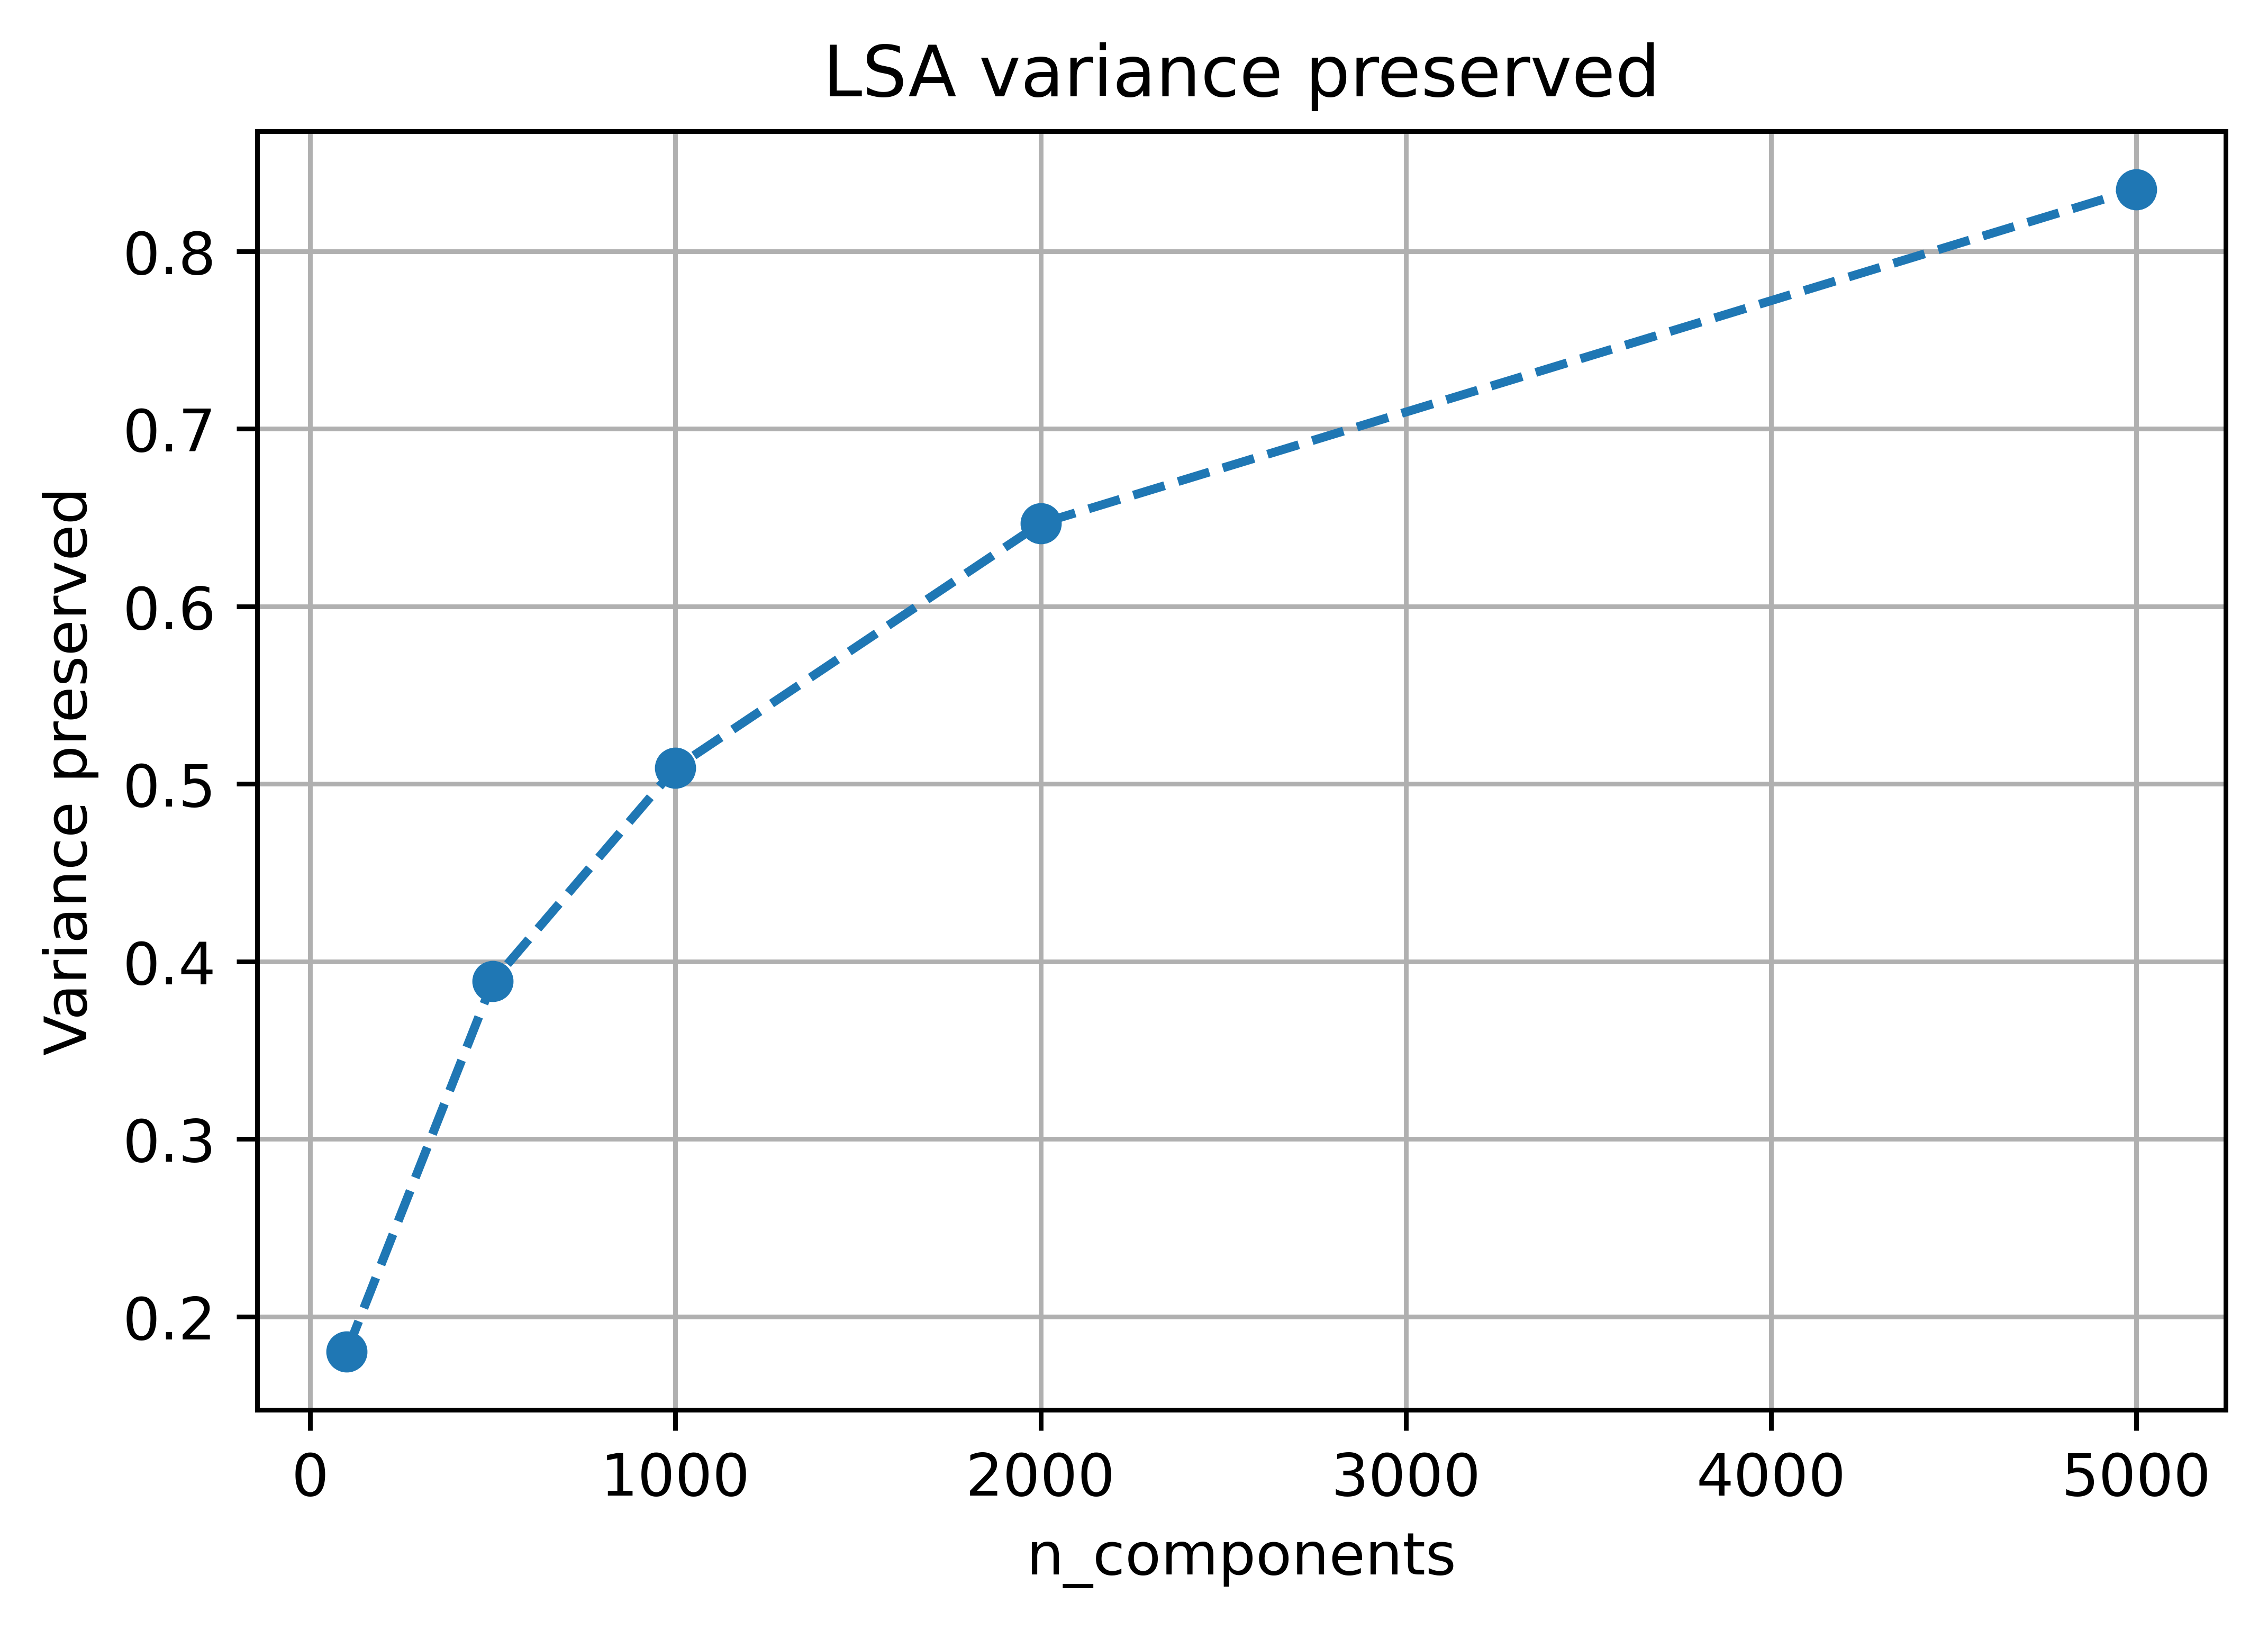

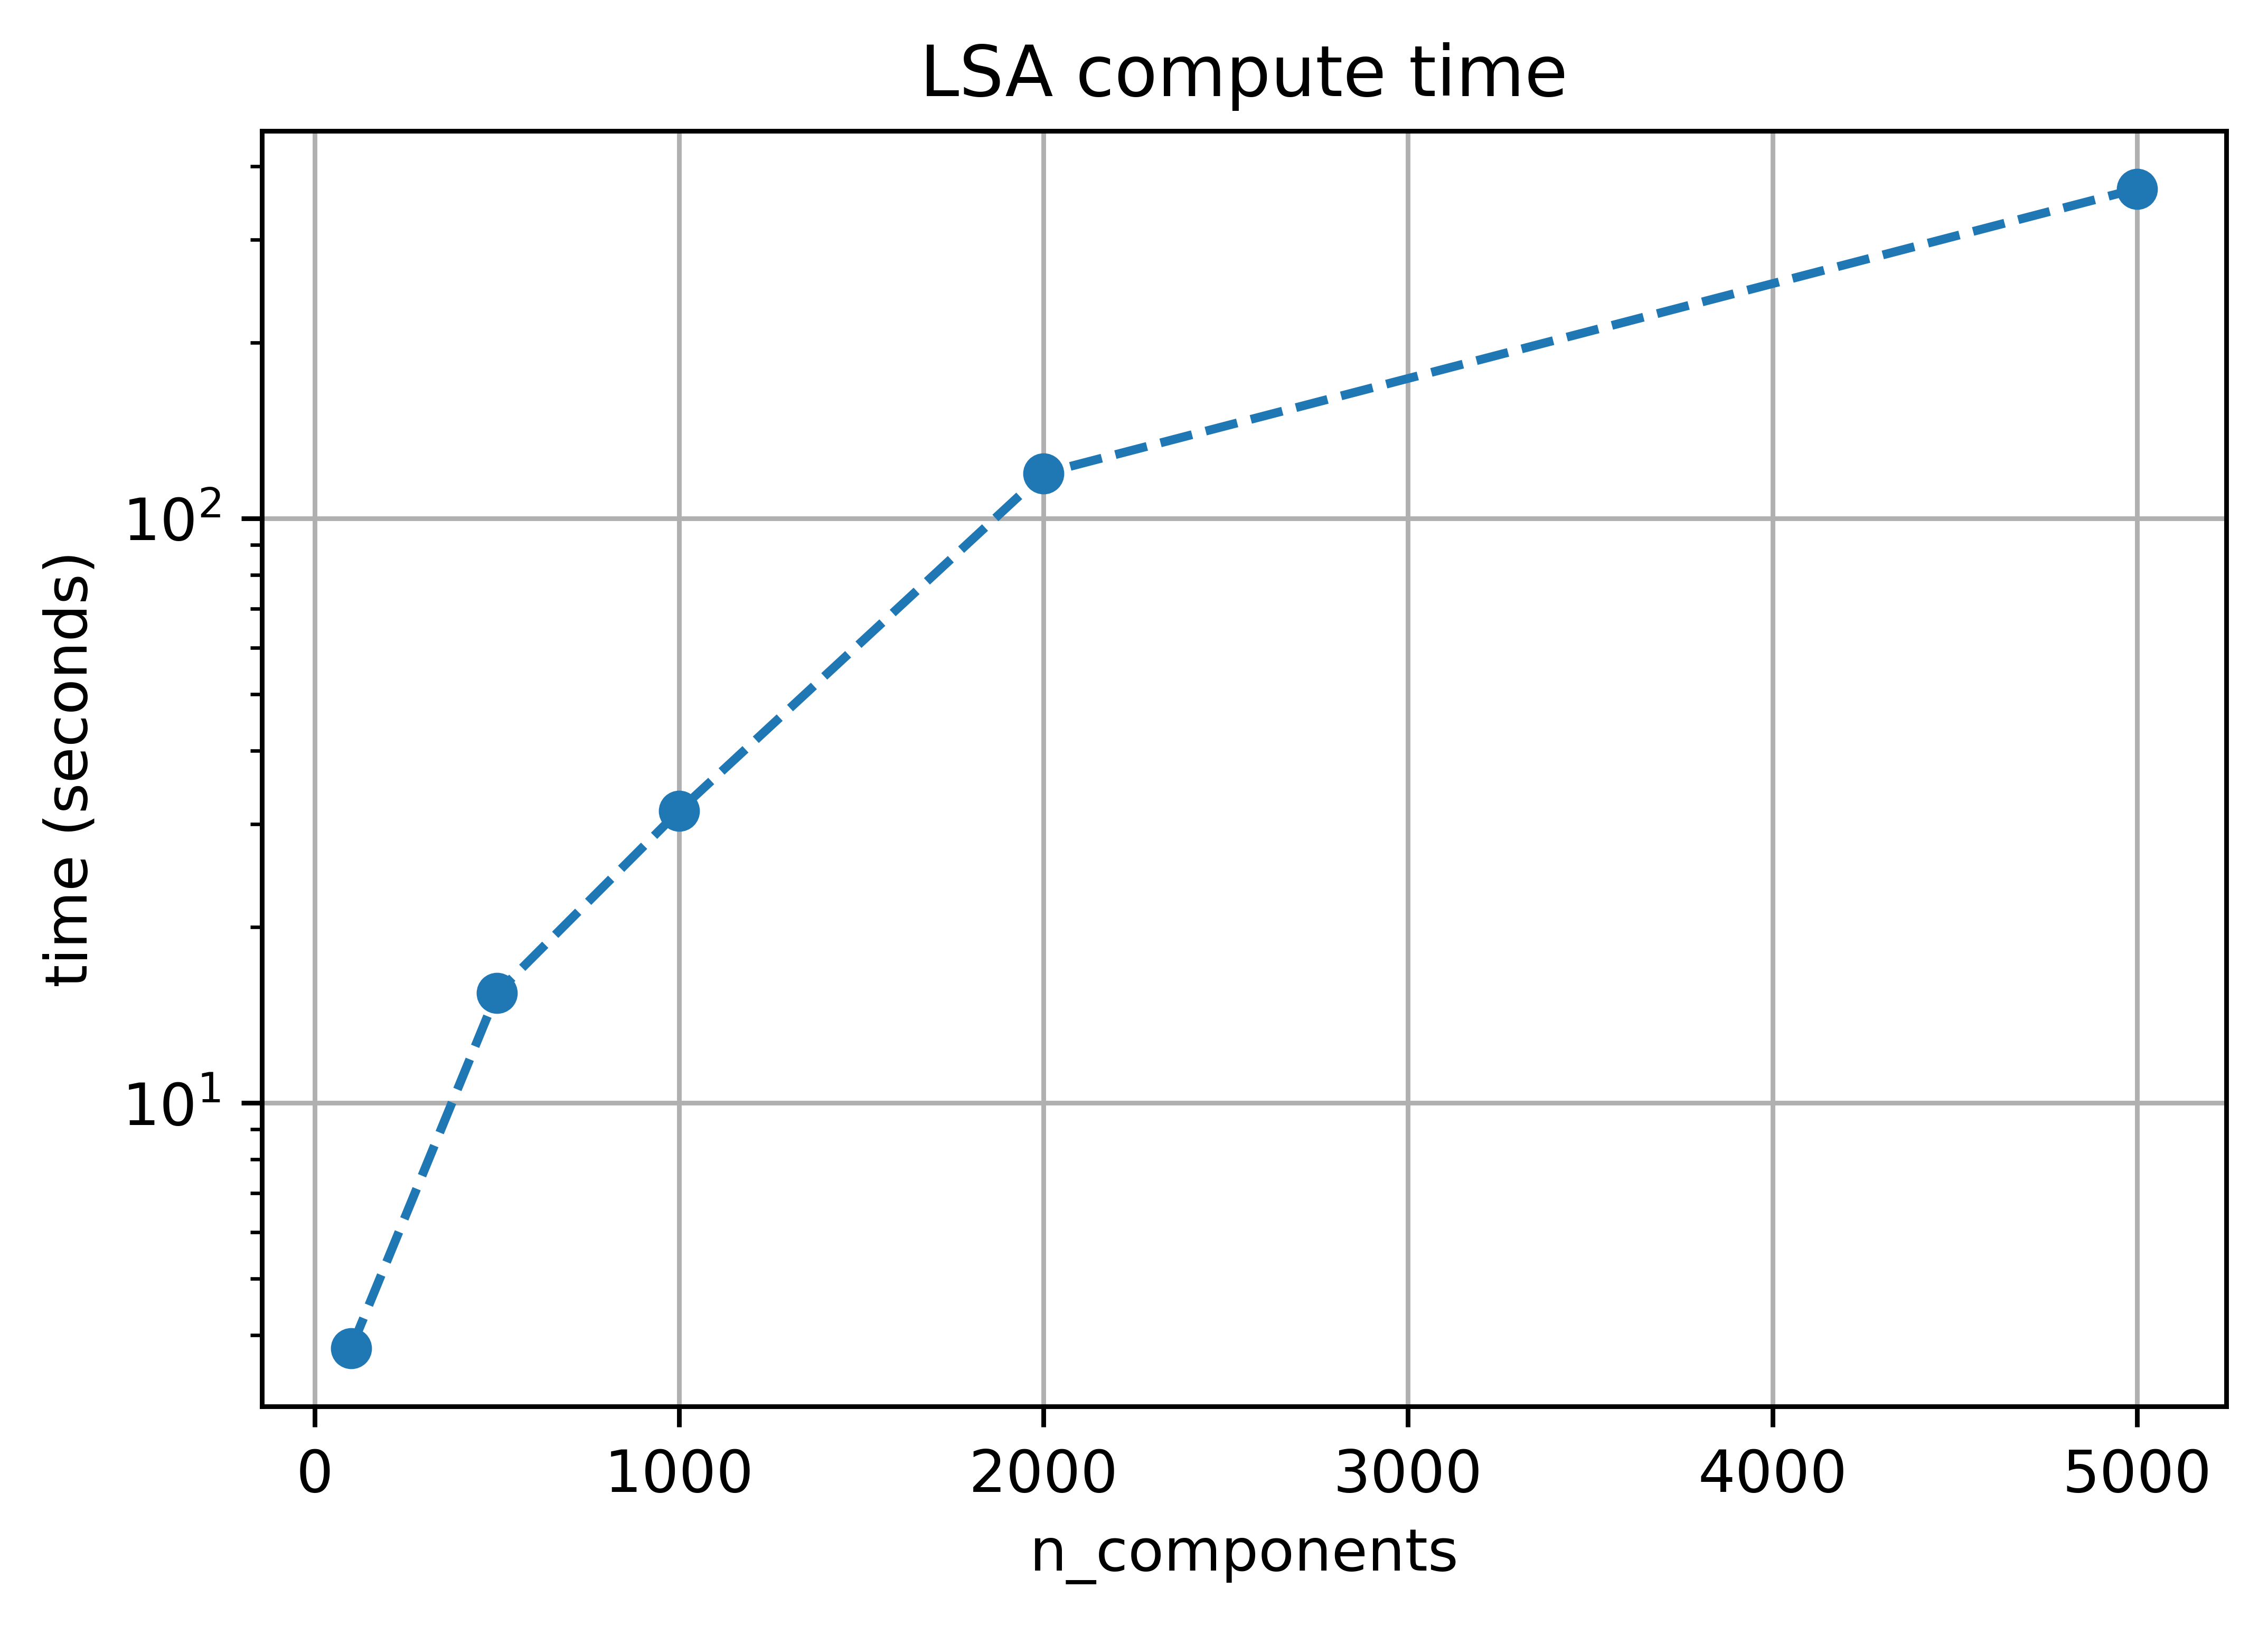

In [59]:
lsi_var_preserved = np.load('./tfidf_results/lsi_var_preserved.npy')
n_components = [100, 500, 1000, 2000, 5000]

fig = figure(dpi=800)
plt.plot(n_components,lsi_var_preserved,linestyle='--', marker='o', label='variance preserved')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Variance preserved')
plt.title('LSA variance preserved')
fig.savefig('tfidf_results/figures/lsi_var_preserved.jpg', bbox_inches='tight')

lsi_time = np.load('./tfidf_results/lsi_time.npy')
fig = figure(dpi=800)
plt.plot(n_components,lsi_time,linestyle='--', marker='o', label='Time (s)')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('time (seconds)')
plt.yscale('log')
plt.title('LSA compute time')
fig.savefig('tfidf_results/figures/lsi_time.jpg', bbox_inches='tight')

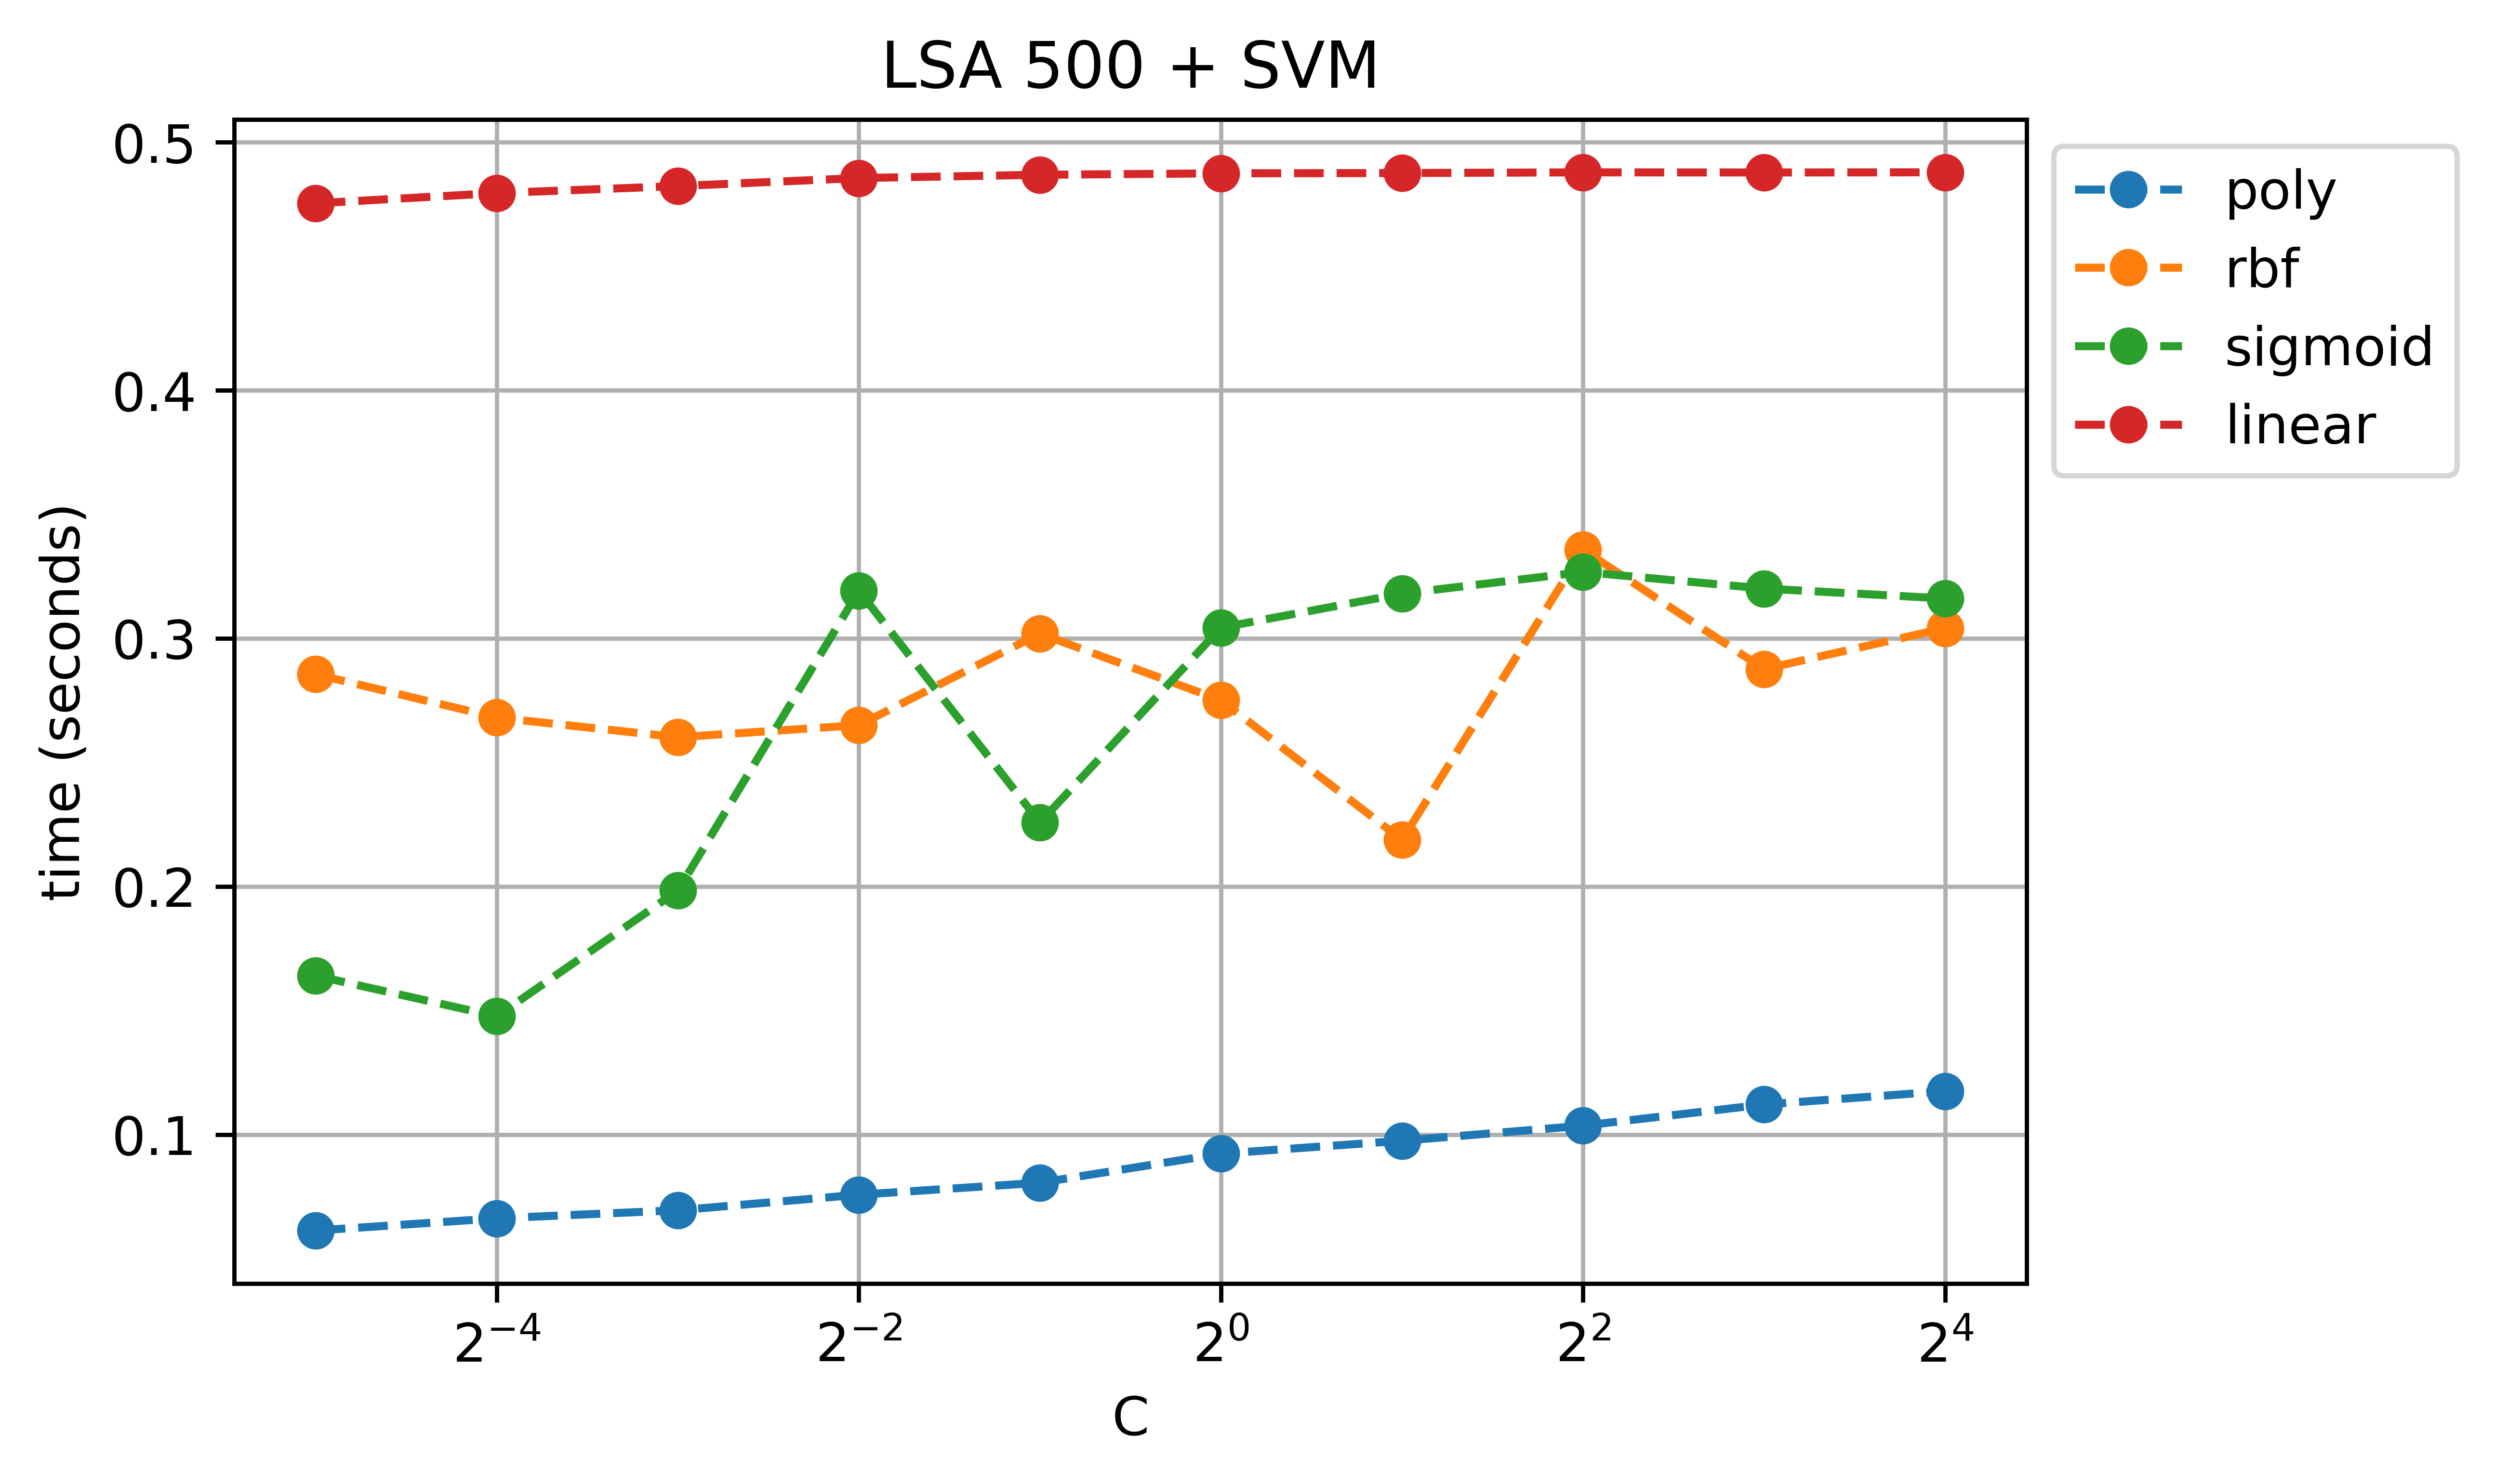

In [65]:
C = [np.float_power(2,i) for i in range(-5,5)]
kernel_scores = np.load('./tfidf_results/svm_kernel_grid.npy', allow_pickle=True).item()
linear_scores = np.load('./tfidf_results/linear_svm_grid.npy', allow_pickle=True)

fig = figure(dpi=800)
for (kernel, results) in kernel_scores.items():
    plt.plot(C, results, linestyle='--', marker='o', label=kernel)

plt.plot(C, linear_scores, linestyle='--', marker='o', label='linear')

plt.grid()
plt.xlabel('C')
plt.ylabel('F1 score')
plt.xscale('log', base=2)
plt.title('LSA 500 + SVM')
plt.legend(bbox_to_anchor=(1, 1))
fig.savefig('tfidf_results/figures/svm.jpg', bbox_inches='tight')

[0.68662659 0.69527397 0.70582891 0.70041295 0.70241093]


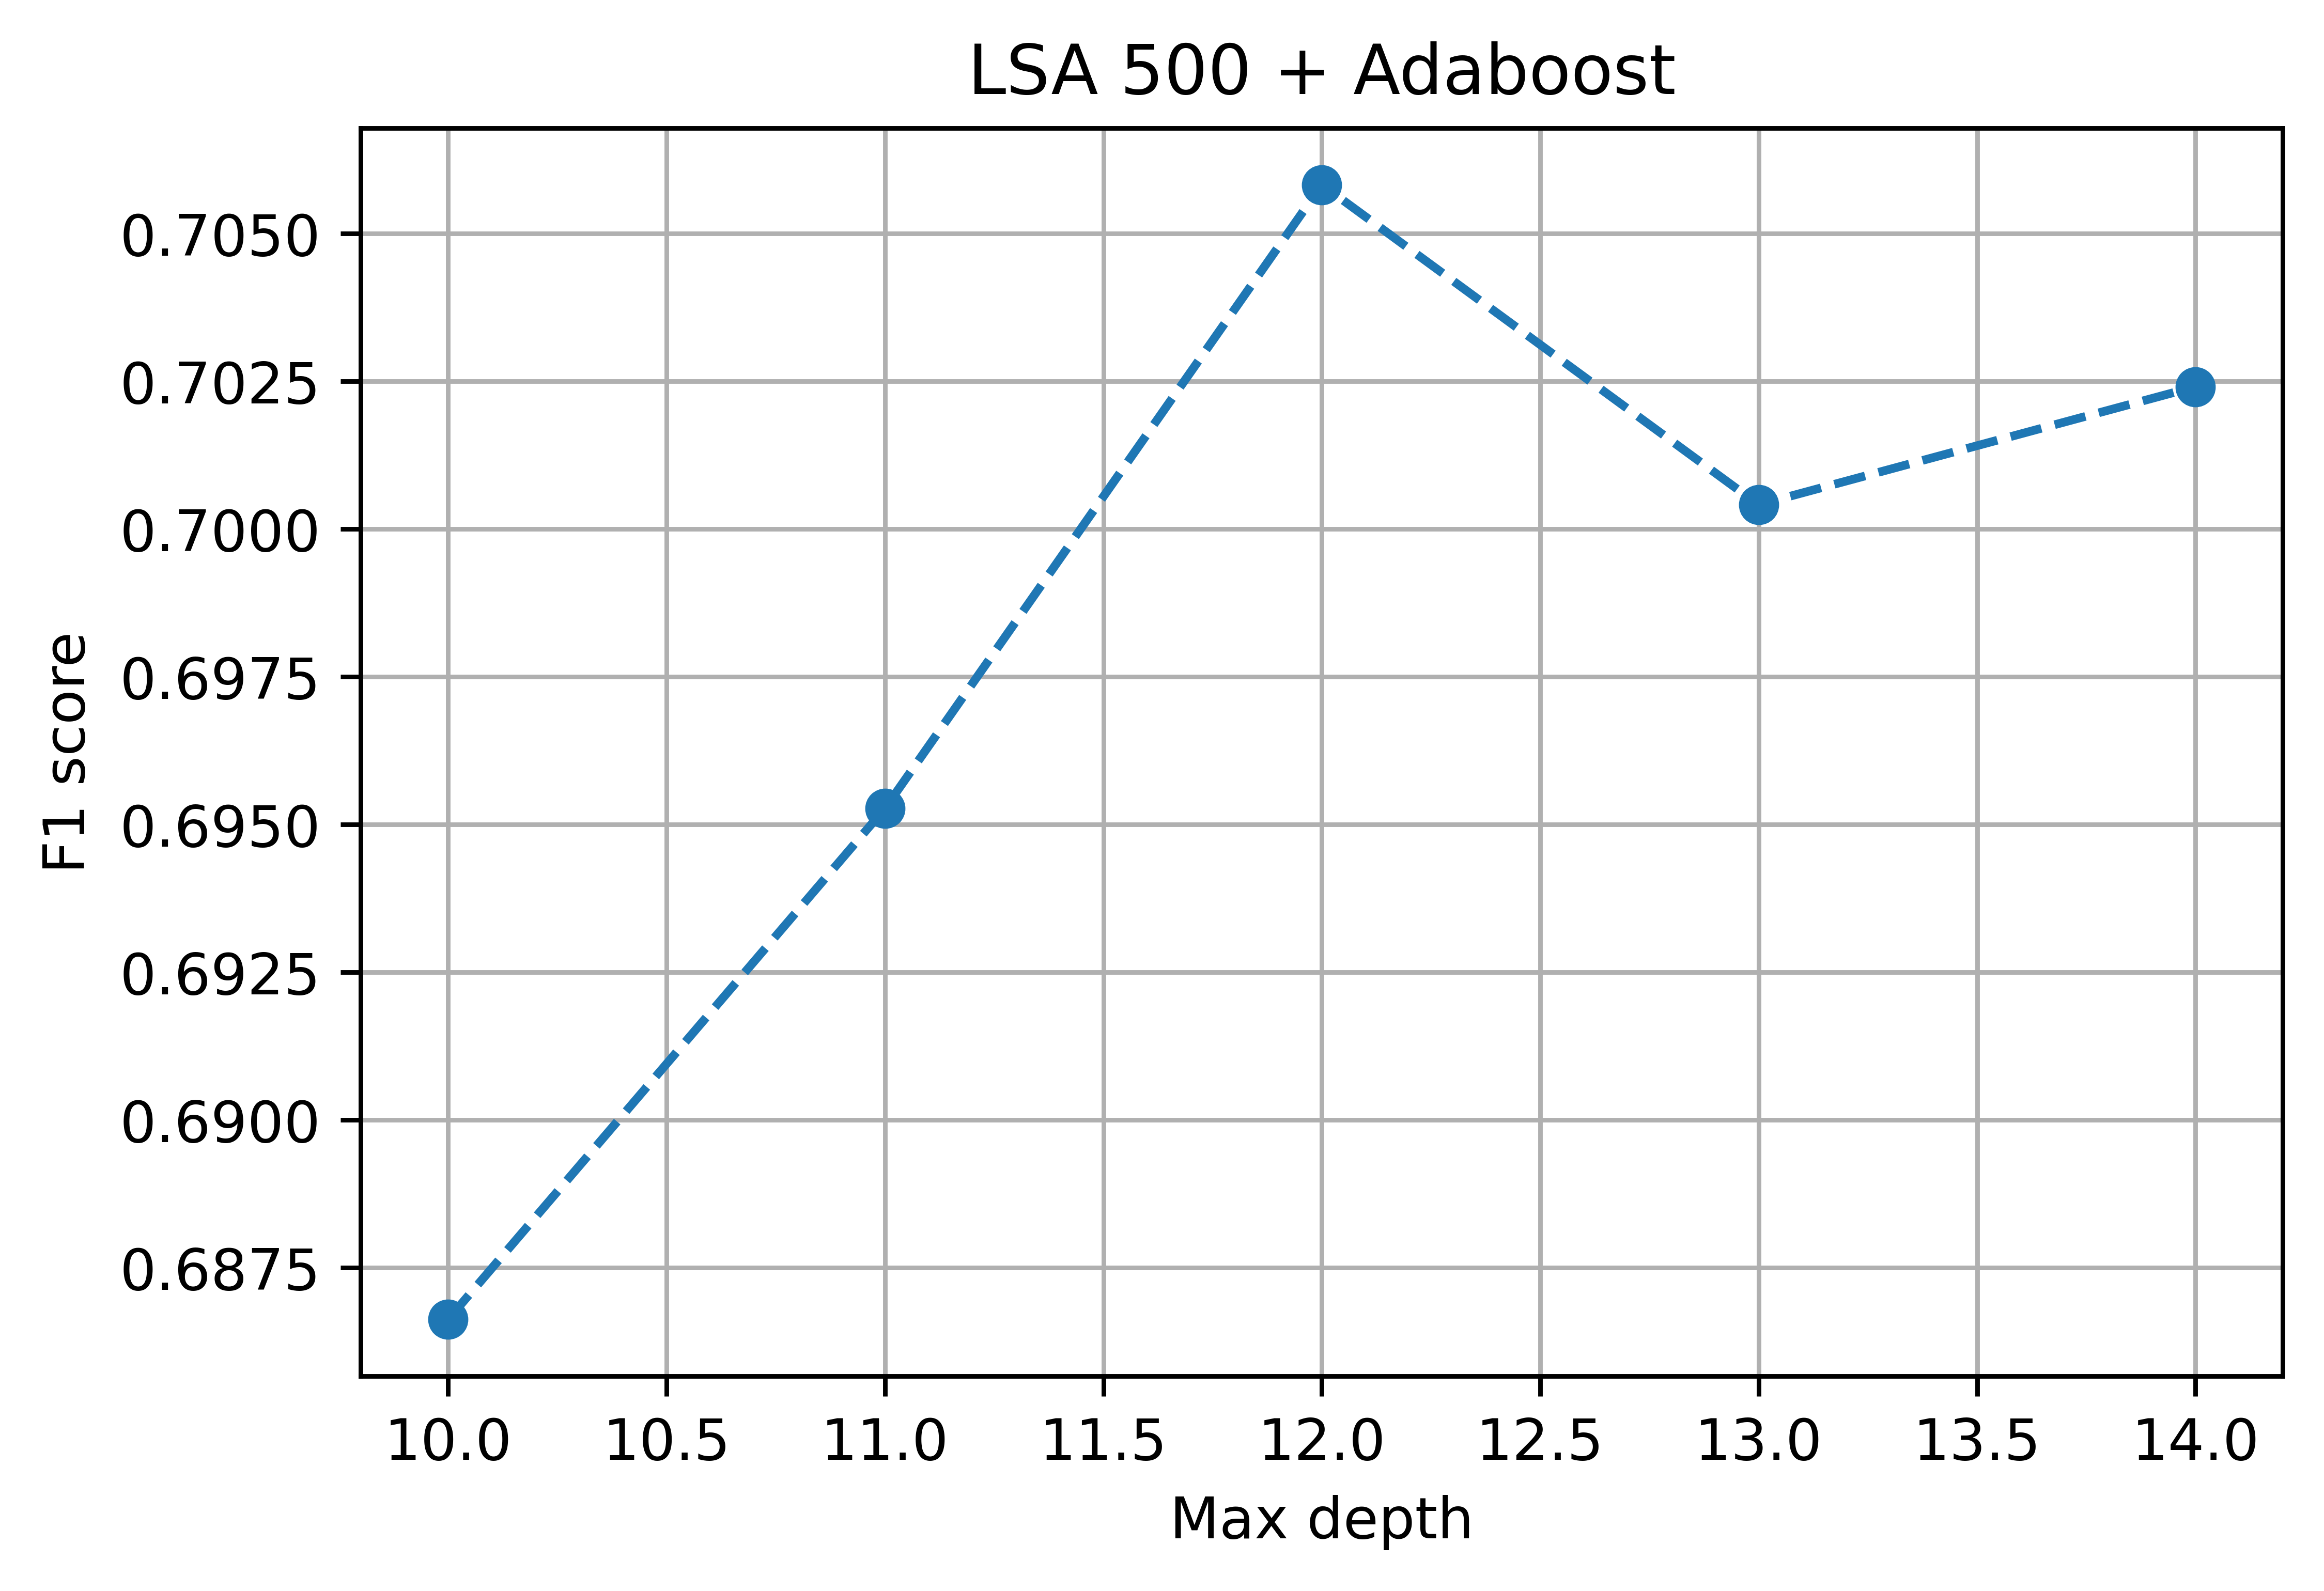

In [77]:
fig = figure(dpi=800)
rf_scores = np.load('./tfidf_results/rf_grid.npy', allow_pickle=True)
plt.plot([10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900], rf_scores, linestyle='--', marker='o')
plt.grid()
plt.xlabel('Number of trees (T)')
plt.ylabel('F1 score')
plt.title('LSA 500 + RF')
fig.savefig('tfidf_results/figures/rf.jpg', bbox_inches='tight')

fig = figure(dpi=800)
adaboost_scores = np.load('./tfidf_results/adaboost_grid.npy', allow_pickle=True)
plt.plot(list(range(10,15)), adaboost_scores, linestyle='--', marker='o')
plt.grid()
plt.xlabel('Max depth')
plt.ylabel('F1 score')
plt.title('LSA 500 + Adaboost')
fig.savefig('tfidf_results/figures/adaboost.jpg', bbox_inches='tight')